In [ ]:
!pip install tensorflow==2.12.0 -q
!pip install h5py -q
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import * # Thêm các lớp bạn cần
import matplotlib.pyplot as plt
import scipy.io as sio

import sys
sys.path.append('/content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main') # Thay đổi đường dẫn này nếu cần

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

import numpy as np
from utils2 import *
from tensorflow.python.keras.layers import *

TensorFlow version: 2.12.0
NumPy version: 1.23.5


In [ ]:
def create_1x64_model():

    Nt, Nr = 64, 1
    # Đầu vào
    imperfect_CSI_input = Input(name='imperfect_CSI_input', shape=(2*Nr*Nt,), dtype=tf.float32)
    perfect_CSI_input = Input(name='perfect_CSI_input', shape=(Nt,), dtype=tf.complex64)
    SNR_input = Input(name='SNR_input', shape=(1,), dtype=tf.float32)

    # Các lớp ẩn
    x = BatchNormalization(name='bn_in')(imperfect_CSI_input) # Chuẩn hóa đầu vào
    x = Dense(256, activation='relu', name='dense_1')(x)
    x = BatchNormalization(name='bn_1')(x)
    # x = tf.keras.layers.Dropout(0.4)(x)

    x = Dense(128, activation='relu', name='dense_2')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Lớp đầu ra
    phase_output = Dense(Nt, activation='sigmoid', name='phase_out')(x)
    scaled_phase = Lambda(lambda p: p * 2 * np.pi, name='scale_phase')(phase_output)
    V_RF_output = Lambda(lambda sp: trans_Vrf(sp, Nt), name='V_RF_out')(scaled_phase)

    rate_output = Lambda(Rate_func, name='rate_out')([perfect_CSI_input, V_RF_output, SNR_input])

    model = Model(inputs=[imperfect_CSI_input, perfect_CSI_input, SNR_input], outputs=rate_output)
    return model

# Train 1x64


Đang tải dữ liệu cho cấu hình 1x64 từ: /content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/10dB/1x64/train
loading data...
Tải dữ liệu hoàn tất.
Shape của kênh ước tính là: (100000, 1, 64)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 imperfect_CSI_input (InputLaye  [(None, 128)]       0           []                               
 r)                                                                                               
                                                                                                  
 bn_in (BatchNormalization)     (None, 128)          512         ['imperfect_CSI_input[0][0]']    
                                                                                                  
 dense_1 (Dense)                (None, 256)          33024       ['bn_in[0][0]'] 

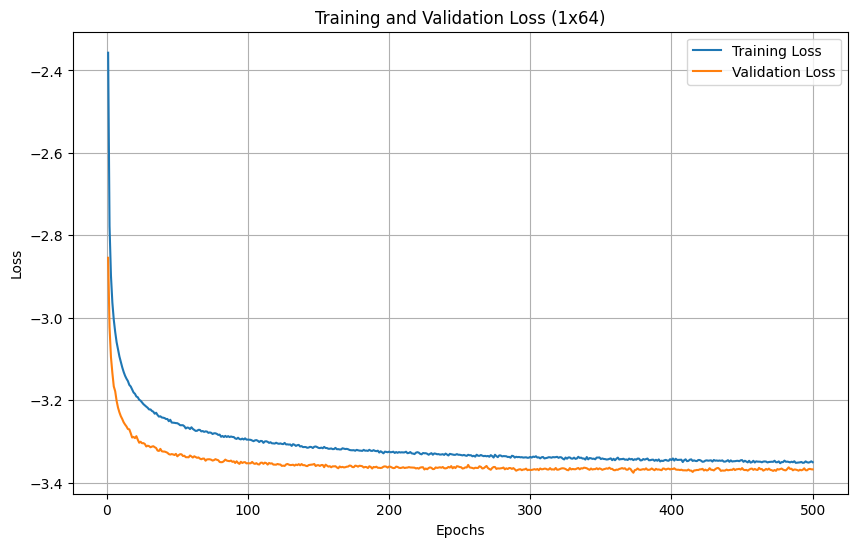

In [ ]:
Nt = 64
Nr = 1
config_str = f'{Nr}x{Nt}'

path = f'/content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/10dB/1x64/train' # Sử dụng file đã gộp
print(f"Đang tải dữ liệu cho cấu hình {config_str} từ: {path}")

H_data, H_est_data = mat_load_train(path)

if H_data is not None:
    # --- TIỀN XỬ LÝ DỮ LIỆU ---
    H_input_real = np.real(H_est_data).reshape(H_est_data.shape[0], -1)
    H_input_imag = np.imag(H_est_data).reshape(H_est_data.shape[0], -1)
    H_input = np.concatenate([H_input_real, H_input_imag], axis=1)

    H_perfect = np.squeeze(H_data)

    # Tạo SNR ngẫu nhiên cho mỗi mẫu
    SNR_data = np.power(10, np.random.randint(-20, 20, [H_perfect.shape[0], 1]) / 10).astype(np.float32)

    dummy_y = np.zeros((H_perfect.shape[0], 1))

    Nt_tf_const = tf.constant(float(Nt), dtype=tf.float32)

    model = create_1x64_model()

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: y_pred)
    model.summary()

    # --- HUẤN LUYỆN MODEL ---
    checkpoint_filepath = f'/content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/10dB/1x64/1x64_10dB.weights.h5'
    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True)

    print(f"\nBắt đầu huấn luyện model cho cấu hình {config_str}...")
    history = model.fit(
        x=[H_input, H_perfect, SNR_data],
        y=dummy_y,
        batch_size=256,
        epochs=500,
        verbose=1,
        validation_split=0.1,
        callbacks=[checkpoint]
    )

    # --- VẼ ĐỒ THỊ LOSS ---
    print("Đã huấn luyện xong. Đang vẽ đồ thị loss...")

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    epochs_range = range(1, len(training_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')

    # Thêm tiêu đề và nhãn cho các trục
    plt.title(f'Training and Validation Loss ({Nr}x{Nt})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Hiển thị chú thích và lưới
    plt.legend()
    plt.grid(True)

    # Hiển thị đồ thị
    plt.show()

# Test 1x64

Attempting to load data from: /content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/20dB/1x64/test
loading data...
Tải dữ liệu hoàn tất.
Shape của kênh ước tính là: (10000, 1, 64)
Shape of H_input (processed imperfect CSI): (10000, 128)
Shape of H (perfect CSI): (10000, 1, 64)
Shape of H (perfect CSI after squeezing): (10000, 64)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 imperfect_CSI_input (InputLaye  [(None, 128)]       0           []                               
 r)                                                                                               
                                                                                                  
 bn_in (BatchNormalization)     (None, 128)          512         ['imperfect_CSI_input[0][0]']    
                                         

1/1 [==============================] - 0s 69ms/step - loss: -9.7026
[0.1851656436920166, 0.50397789478302, 1.157216191291809, 2.1699910163879395, 3.4478213787078857, 4.8957648277282715, 6.449189186096191, 8.061628341674805, 9.70264720916748]


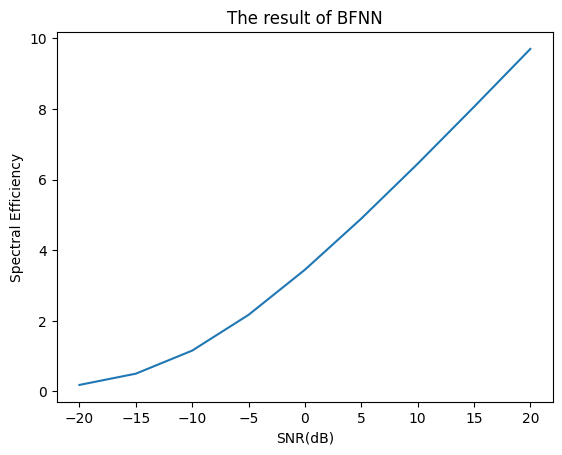

In [ ]:
# ------------------------------------------
#  Load and generate simulation data
# ------------------------------------------
path = '/content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/20dB/1x64/test'  # the path of the dictionary containing pcsi.mat and ecsi.mat
print(f"Attempting to load data from: {path}")
H, H_test_estimated = mat_load_train(path)

if H_test_estimated is None or H is None:
    print("Error: Data loading failed. Please check the path and file names.")
else:
    H_input_real = np.real(H_test_estimated).reshape(H_test_estimated.shape[0], -1)
    H_input_imag = np.imag(H_test_estimated).reshape(H_test_estimated.shape[0], -1)
    H_input_for_testing = np.concatenate([H_input_real, H_input_imag], axis=1)
    print(f"Shape of H_input (processed imperfect CSI): {H_input_for_testing.shape}")
    print(f"Shape of H (perfect CSI): {H.shape}")

    H = np.squeeze(H)
    print(f"Shape of H (perfect CSI after squeezing): {H.shape}")

    model = create_1x64_model()

    # the y_pred is the actual rate, thus the loss is y_pred, without labels
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: y_pred)
    model.summary()

    # -----------------------
    #  Test Your Model
    # -----------------------

    num_test_samples = H_input_for_testing.shape[0]
    dummy_y_test = np.zeros((num_test_samples, 1))

    rate = []
    # load the trained model
    model.load_weights(f'/content/drive/MyDrive/Khoa_luan_tot_nghiep/BF-design-with-DL-main/test/20dB/1x64/1x64_20dB.weights.h5')
    for snr in range(-20, 25, 5):
        SNR = np.power(10, np.ones([H.shape[0], 1]) * snr / 10)
        y = model.evaluate(x=[H_input_for_testing, H, SNR], y=dummy_y_test, batch_size=10000)
        rate.append(-y)
    print(rate)

    plt.title("The result of BFNN")
    plt.xlabel("SNR(dB)")
    plt.ylabel("Spectral Efficiency")
    plt.plot(range(-20, 25, 5), rate)
    plt.show()

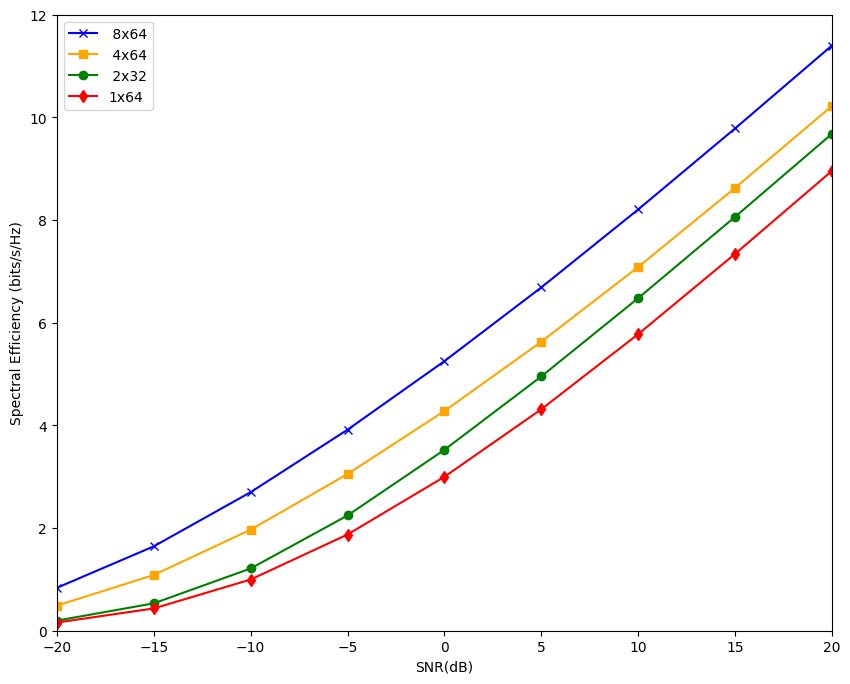

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


rate10 = [0.1594395786523819, 0.4340885281562805, 0.9973938465118408, 1.8744261264801025, 2.9983255863189697, 4.313107967376709, 5.777017116546631, 7.340055465698242, 8.957158088684082]

rate2x32 = [0.19714190065860748, 0.5334809422492981, 1.2125340700149536, 2.2450549602508545, 3.5237624645233154, 4.9534912109375, 6.478175640106201, 8.061477661132812, 9.678894996643066] #2x32 10dB

rate4x64 = [0.48936381936073303, 1.085632085800171, 1.9684693813323975, 3.0524563789367676, 4.279143810272217, 5.628354072570801, 7.08534049987793, 8.625697135925293, 10.221379280090332]  #4x64 10dB

rate8x64 = [0.8362618088722229, 1.6437695026397705, 2.699007749557495, 3.9158754348754883, 5.251380920410156, 6.687224864959717, 8.205809593200684, 9.783935546875, 11.399506568908691] #8x64 10dB

# Trục x
snr_axis = list(range(-20, 25, 5))

# Vẽ đồ thị
plt.figure(figsize=(10, 8))
# plt.title("The result of BFNN")
plt.xlabel("SNR(dB)")
plt.ylabel("Spectral Efficiency (bits/s/Hz)")

plt.grid(False)

plt.plot(snr_axis, rate8x64, color = "Blue", marker ='x', linestyle = '-', label = ' 8x64')

plt.plot(snr_axis, rate4x64, color = 'Orange', marker='s', linestyle='-', label=' 4x64')

plt.plot(snr_axis, rate2x32, color = 'Green', marker='o', linestyle='-', label=' 2x32')

plt.plot(snr_axis, rate10, color = "red", marker ='d', linestyle = '-', label = '1x64')


# legend
plt.legend()
plt.xticks(snr_axis)

plt.xlim(min(snr_axis), max(snr_axis))
plt.ylim(0, 12)
plt.show()

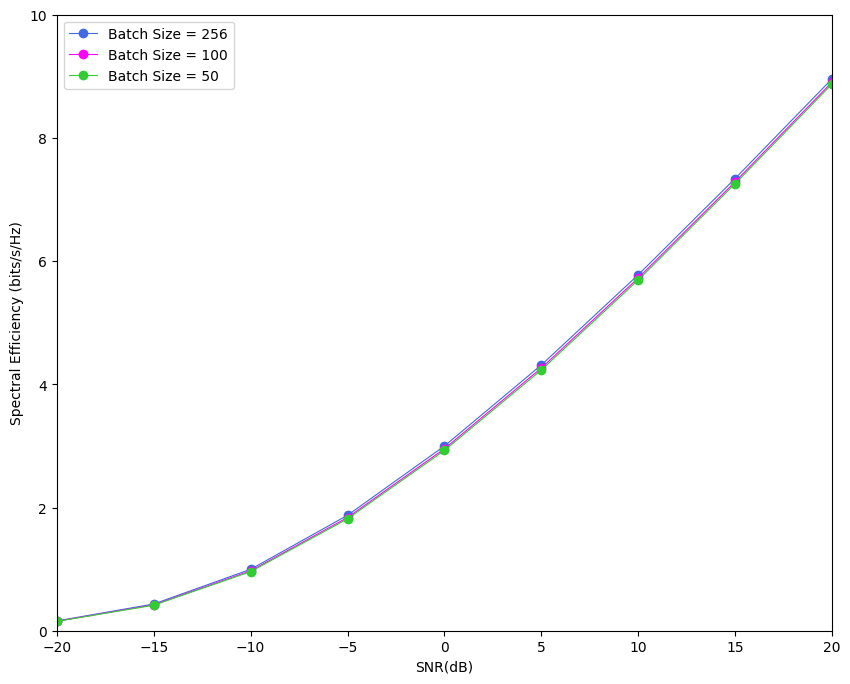

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


rate10 = [0.1594395786523819, 0.4340885281562805, 0.9973938465118408, 1.8744261264801025, 2.9983255863189697, 4.313107967376709, 5.777017116546631, 7.340055465698242, 8.957158088684082]
rate10_100bs = [0.15419664978981018, 0.4210398495197296, 0.9722083806991577, 1.8374253511428833, 2.9533188343048096, 4.263313293457031, 5.724448204040527, 7.286154747009277, 8.90276050567627]
rate10_50bs = [0.15176554024219513, 0.4147901237010956, 0.9593556523323059, 1.816847324371338, 2.9262309074401855, 4.232573509216309, 5.693289756774902, 7.25602912902832, 8.873370170593262]

# Trục x
snr_axis = list(range(-20, 25, 5))

# Vẽ đồ thị
plt.figure(figsize=(10, 8))
# plt.title("The result of BFNN")
plt.xlabel("SNR(dB)")
plt.ylabel("Spectral Efficiency (bits/s/Hz)")

plt.grid(False)

plt.plot(snr_axis, rate10, color = 'royalblue', marker='o', linestyle='-', linewidth=0.8, label='Batch Size = 256')

plt.plot(snr_axis, rate10_100bs, color = 'fuchsia', marker='o', linestyle='-', linewidth=0.8, label='Batch Size = 100')

plt.plot(snr_axis, rate10_50bs, color = 'limegreen', marker='o', linestyle='-', linewidth=0.8, label='Batch Size = 50')

plt.legend()
plt.xticks(snr_axis)

plt.xlim(min(snr_axis), max(snr_axis))
plt.ylim(0, 10)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Figure for different Learning Rate.

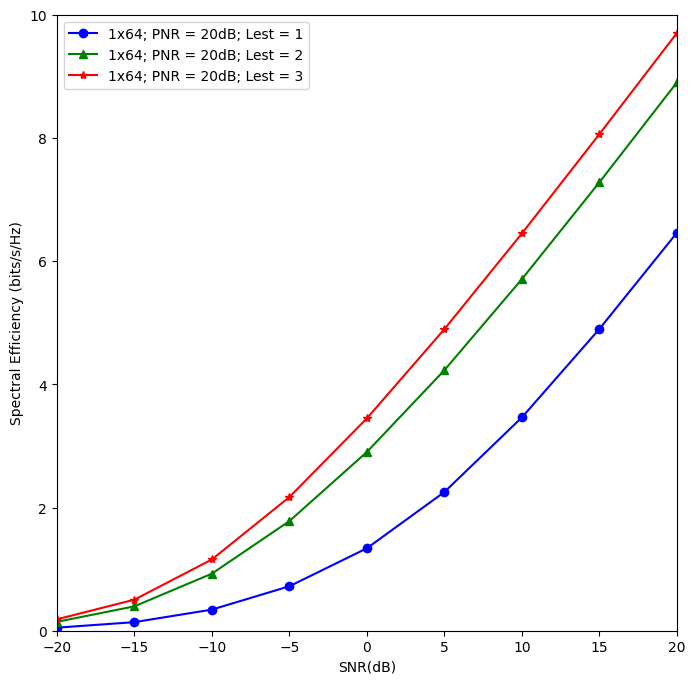

In [ ]:
rate_Lest_3 = [0.1851656436920166, 0.50397789478302, 1.157216191291809, 2.1699910163879395, 3.4478213787078857, 4.8957648277282715, 6.449189186096191, 8.061628341674805, 9.70264720916748]

rate_Lest_2 = [0.14392127096652985, 0.3959406316280365, 0.9265726804733276, 1.7799021005630493, 2.9020307064056396, 4.2297186851501465, 5.707579612731934, 7.279565811157227, 8.901344299316406]

rate_Lest_1 = [0.049519989639520645, 0.13924577832221985, 0.3428138792514801, 0.7218999862670898, 1.3387360572814941, 2.251603364944458, 3.463059663772583, 4.89840841293335, 6.46102237701416]

# Trục x
snr_axis = list(range(-20, 25, 5))

# Vẽ đồ thị
plt.figure(figsize=(8, 8))

plt.xlabel("SNR(dB)")
plt.ylabel("Spectral Efficiency (bits/s/Hz)")

plt.grid(False)


plt.plot(snr_axis, rate_Lest_1, color = 'blue', marker='o', linestyle='-', label='1x64; PNR = 20dB; Lest = 1')

plt.plot(snr_axis, rate_Lest_2, color = 'green', marker='^', linestyle='-', label='1x64; PNR = 20dB; Lest = 2')

plt.plot(snr_axis, rate_Lest_3, color = 'red', marker='*', linestyle='-', label='1x64; PNR = 20dB; Lest = 3')


# legend
plt.legend()
plt.xticks(snr_axis)

plt.xlim(min(snr_axis), max(snr_axis))
plt.ylim(0, 10)

plt.show()

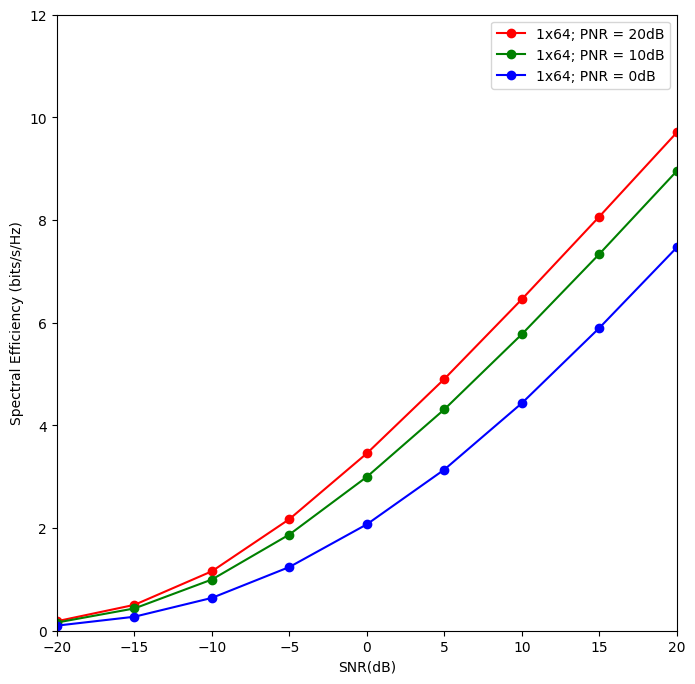

In [ ]:
rate_1x64_20dB = [0.1849747747182846, 0.5038788318634033, 1.1583876609802246, 2.174239158630371, 3.455592632293701, 4.905555248260498, 6.458557605743408, 8.069061279296875, 9.708091735839844]
rate_1x64_10dB = [0.1594395786523819, 0.4340885281562805, 0.9973938465118408, 1.8744261264801025, 2.9983255863189697, 4.313107967376709, 5.777017116546631, 7.340055465698242, 8.957158088684082]
rate_1x64_0dB = [0.09906554967164993, 0.2725054919719696, 0.6393226981163025, 1.2412139177322388, 2.0731773376464844, 3.140141010284424, 4.434063911437988, 5.899853706359863, 7.467811107635498]

snr_axis = list(range(-20, 25, 5))

# Vẽ đồ thị
plt.figure(figsize=(8, 8))

plt.xlabel("SNR(dB)")
plt.ylabel("Spectral Efficiency (bits/s/Hz)")

plt.grid(False)

plt.plot(snr_axis, rate_1x64_20dB, color = 'red', marker='o', linestyle='-', label='1x64; PNR = 20dB')
plt.plot(snr_axis, rate_1x64_10dB, color = 'green', marker='o', linestyle='-', label='1x64; PNR = 10dB')
plt.plot(snr_axis, rate_1x64_0dB, color = 'blue', marker='o', linestyle='-', label='1x64; PNR = 0dB')

# legend
plt.legend()
plt.xticks(snr_axis)

plt.xlim(min(snr_axis), max(snr_axis))
plt.ylim(0, 12)

plt.show()